## Predicting origin of apples based on spectral data 

### About this notebook

- The dataset consists of NIR spectroscopy data of 300 apples
- The apples belong to 3 categories - Fuji apples, Red Star apples and Gala apples
- There are 100 samples of each type 
- The apples come from two provinces - Shaanxi and Shandong - 50 from each (50 * 2 * 3 = 300 samples)
- The intention is to use this data and build a classifier that can identify the source of the apples based on its spectral signature


### Process followed:
- After importing the data we do some initial preprocessing on it
- To adjust for the noise present in the data, we perform Savitzky-Golay smoothing 
- After that, we do Multiplicative Scatter Correction - a normalization technique for spectral data
- Post this, by PCA the best 6 components are picked 
- On this data, we use Support Vector Machines as the classifier of choice
- After training the SVM separately on each apple category, we predict the category for the test data

### Reference for the dataset and procedure:
Li, C., Li, L., Wu, Y., Lu, M., Yang, Y., &; Li, L. (2018). Apple variety identification using near-infrared spectroscopy. Journal of Spectroscopy, 2018, 1–7. https://doi.org/10.1155/2018/6935197

###For helping me understand MSC and the implementation too:
https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

Import the Libraries

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

Importing the dataset

In [5]:
df = pd.read_excel('apple_NIR_dataset.xlsx')
# print(df.head().to_string())

Cleaning up the data

In [6]:
# remove first two columns
df = df.drop(df.columns[[0,1]], axis=1) 
print(df.head().to_string())

      400.093     400.463     400.834     401.204     401.574     401.944     402.314     402.685     403.055     403.425     403.795     404.165     404.535     404.905     405.275     405.644     406.014     406.384     406.754     407.123     407.493     407.863     408.232     408.602     408.972     409.341     409.711      410.08     410.449     410.819     411.188     411.557     411.927     412.296     412.665     413.034     413.403     413.772     414.142     414.511      414.88     415.248     415.617     415.986     416.355     416.724     417.093     417.461      417.83     418.199     418.567     418.936     419.305     419.673     420.042      420.41     420.778     421.147     421.515     421.884     422.252      422.62     422.988     423.356     423.725     424.093     424.461     424.829     425.197     425.565     425.933     426.301     426.668     427.036     427.404     427.772      428.14     428.507     428.875     429.242      429.61     429.978     430.345   

Convert the values of reflectance to absorbance

In [7]:
def get_absorbance(reflectance):
  return np.log(1/reflectance)

df = df.apply(get_absorbance)

print(df.head().to_string())

    400.093   400.463   400.834   401.204   401.574   401.944   402.314   402.685   403.055   403.425   403.795   404.165   404.535   404.905   405.275   405.644   406.014   406.384   406.754   407.123   407.493   407.863   408.232   408.602   408.972   409.341   409.711    410.08   410.449   410.819   411.188   411.557   411.927   412.296   412.665   413.034   413.403   413.772   414.142   414.511    414.88   415.248   415.617   415.986   416.355   416.724   417.093   417.461    417.83   418.199   418.567   418.936   419.305   419.673   420.042    420.41   420.778   421.147   421.515   421.884   422.252    422.62   422.988   423.356   423.725   424.093   424.461   424.829   425.197   425.565   425.933   426.301   426.668   427.036   427.404   427.772    428.14   428.507   428.875   429.242    429.61   429.978   430.345   430.713    431.08   431.447   431.815   432.182   432.549   432.917   433.284   433.651   434.018   434.385   434.752   435.119   435.486   435.853    436.22   436.58

Use Savitzy-Golay smoothing with a window size of 5

In [8]:
from scipy.signal import savgol_filter

filtered = savgol_filter(df, 5, 3, axis=0)

Convert the filtered data back to dataframe


In [9]:
# print(filtered)
filtered_df = pd.DataFrame(filtered[:,:])

Plot the original data

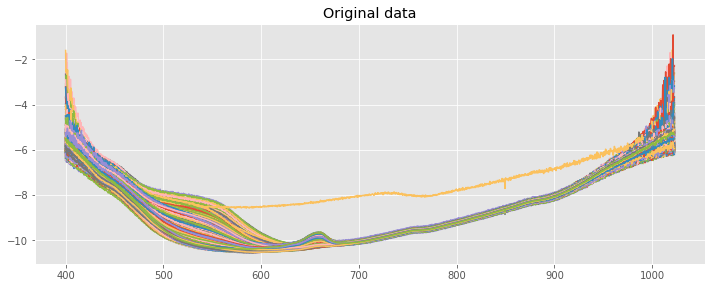

In [10]:
X = df.values[:,:]
# Readings are between 400 nm to 1021 nm with an interval of about 0.33 nm, which resulted in 1888 observations 
wl = np.arange(400,1023.04,0.33)
 
# Plot the spectra
plt.figure(figsize=(12,15))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(311)
    plt.plot(wl, X.T)
    plt.title('Original data')

Plot the filtered data

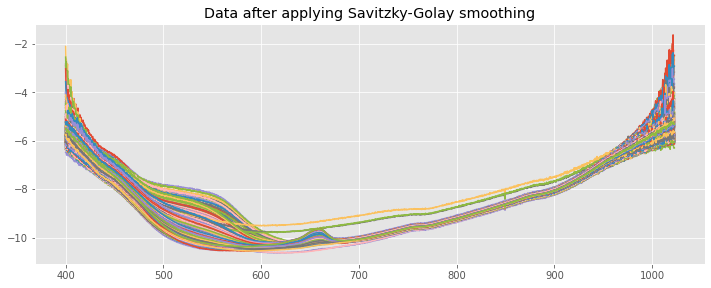

In [11]:
X = filtered_df.values[:,:]
wl = np.arange(400,1023.04,0.33)
 
# Plot the spectra
plt.figure(figsize=(12,15))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(311)
    plt.plot(wl, X.T)
    plt.title('Data after applying Savitzky-Golay smoothing')

Perform Multiplicative scatter correction

In [12]:
def msc(input_data, reference=None):
  # mean centre correction
  for i in range(input_data.shape[0]):
    input_data[i,:] -= input_data[i,:].mean()

  # Get the reference spectrum. If not given, estimate it from the mean    
  if reference is None:    
    # Calculate mean
    ref = np.mean(input_data, axis=0)
  else:
    ref = reference

  # Define a new array and populate it with the corrected data    
  data_msc = np.zeros_like(input_data)
  for i in range(input_data.shape[0]):
    # Run regression
    fit = np.polyfit(ref, input_data[i,:], 1, full=True)
    # Apply correction
    data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 

  return (data_msc, ref)

Plot data after MSC

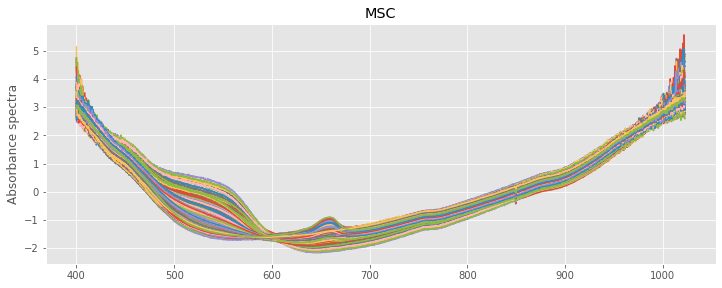

In [13]:
Xmsc = msc(X)[0] # Take the first element of the output tuple

plt.figure(figsize=(12,15))
with plt.style.context(('ggplot')):
  ax2 = plt.subplot(312)
  plt.plot(wl, Xmsc.T)
  plt.ylabel('Absorbance spectra')
  plt.title('MSC')

Perform PCA - 2 dimensions for the first apple category - Fuji Apples (samples 0-100)

In [14]:
# do PCA separately for each apple category

from sklearn.preprocessing import StandardScaler
# Separating out the features
x = Xmsc[:100,:]
# Standardizing the features
# x = StandardScaler().fit_transform(x)
pre_pca_data = x

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

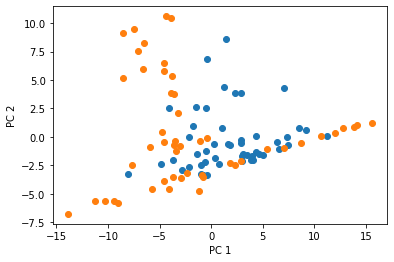

In [16]:
x = principalDf['PC1']
y = principalDf['PC2']

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.scatter(x[:50],y[:50])
plt.scatter(x[50:],y[50:])

PCA - 3 Dimensions

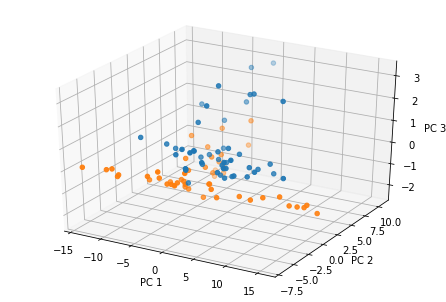

In [22]:
from mpl_toolkits.mplot3d import Axes3D

pca3d = PCA(n_components=3)
principalComponents = pca3d.fit_transform(pre_pca_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3'])

# same but with 3 principal components

fig = plt.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = principalDf['PC1']
sequence_containing_y_vals = principalDf['PC2']
sequence_containing_z_vals = principalDf['PC3']


ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.scatter(sequence_containing_x_vals[:50], sequence_containing_y_vals[:50], sequence_containing_z_vals[:50])
ax.scatter(sequence_containing_x_vals[50:], sequence_containing_y_vals[50:], sequence_containing_z_vals[50:])
plt.show()

Doing PCA on 6 dimensions - to use SVMs

In [23]:
pca6d = PCA(n_components=6)
principalComponents = pca6d.fit_transform(pre_pca_data)
principalDf = pd.DataFrame(data = principalComponents)

In [24]:
pd.DataFrame(data = principalComponents)

,0,1,2,3,4,5
0,-0.942509,-3.220154,0.138114,0.424897,0.601934,-0.419641
1,-0.441517,-3.345160,-0.392078,0.541703,0.229304,0.151066
2,4.006739,-2.026991,-0.137575,0.480020,-0.329223,0.701655
3,6.601904,-1.026434,-0.102211,0.132553,-0.195783,0.737596
4,4.646513,-1.472125,-0.123732,0.094045,0.153305,0.369047
...,...,...,...,...,...,...
95,-3.493075,-0.319648,-0.490673,-0.825097,-0.542898,-0.208123
96,-5.952594,-0.845182,-1.077713,-0.857034,-0.552983,-0.267085
97,-3.638568,-0.751211,-1.183464,-0.999970,-0.396724,-0.021383
98,-1.080937,-0.356252,-1.594619,-1.119301,0.035493,0.354680


In [25]:
# Use kernel SVM here
from sklearn.model_selection import train_test_split
X = principalDf
# predictions - first 50 are type A apples (0) and second 50 are type B (1)
z = [0] * 100
z[50:] = [1] * 50
X_train, X_test, y_train, y_test = train_test_split(X, z, test_size = 0.25)

In [26]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [27]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf')
classifier.fit(X_train, y_train)

SVC()

In [28]:
y_pred = classifier.predict(X_test)
# print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

In [29]:
print(y_pred)
print(np.array(y_test))
# all predictions match
# 1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1
# 1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1

[1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0]
[1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0]


Predicting for the second category - Red Star apples (samples 100-200)

In [35]:
x = Xmsc[100:200,:]
# x = StandardScaler().fit_transform(x)
pre_pca_data = x

# Doing PCA on 6 dimensions

pca6d = PCA(n_components=6)
principalComponents = pca6d.fit_transform(pre_pca_data)
principalDf = pd.DataFrame(data = principalComponents)

# Use kernel SVM here
X = principalDf
# predictions - first 50 are type A apples and second 50 are type B
z = [0] * 100
z[50:] = [1] * 50

X_train, X_test, y_train, y_test = train_test_split(X, z, test_size = 0.25)

sc = StandardScaler()
# SCALING DONE TWICE - REMOVE ONE
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [38]:
print(y_pred)
print(np.array(y_test))

# to check how many predictions match
# np.logical_xor(y_pred, np.array(y_test))

[0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1]
[0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1]


Predicting for the third category - Gala Apples (samples 200-300)

In [40]:
x = Xmsc[200:300,:]
# x = StandardScaler().fit_transform(x)
pre_pca_data = x

# Doing PCA on 6 dimensions

pca6d = PCA(n_components=6)
principalComponents = pca6d.fit_transform(pre_pca_data)
principalDf = pd.DataFrame(data = principalComponents)

# Use kernel SVM here
X = principalDf
# predictions - first 50 are type A apples and second 50 are type B
z = [0] * 100
z[50:] = [1] * 50

X_train, X_test, y_train, y_test = train_test_split(X, z, test_size = 0.25)

sc = StandardScaler()
# SCALING DONE TWICE - REMOVE ONE
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.svm import SVC

classifier = SVC(kernel = 'rbf')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(y_pred)
print(np.array(y_test))


[1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 1]
[1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 1]
